## This is linear regression problem of learning the mapping between two sets of coordinates.

### X = A set of points in 3D space, of dimension (m,3), m = number of points
### Y = X rotated and translated by some arbitrary rotation & translation, dimension (m,3)


In [36]:
%matplotlib inline
import requests
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from scipy.optimize import minimize, least_squares

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import SGD, Adam

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error as mse

## Rotation Matrix for Euler angles alpha, beta, gamma 

In [140]:
def generate_rotation_matrix(angles):
    """ generate rotation matrix defined by Euler angles alpha, beta, gamma """

    mat = np.zeros((3,3))
#     alpha, beta, gamma = np.deg2rad(angles_in_deg)
    alpha, beta, gamma = angles

    ca = np.cos(alpha)
    cb = np.cos(beta)
    cg = np.cos(gamma)
    sa = np.sin(alpha)
    sb = np.sin(beta)
    sg = np.sin(gamma)

    mat[0,0] = ca*cb
    mat[0,1] = ca*sb*sg - sa*cg
    mat[0,2] = ca*sb*cg + sa*sg

    mat[1,0] = sa*cb
    mat[1,1] = sa*sb*sg + ca*cg
    mat[1,2] = sa*sb*cg - ca*sg

    mat[2,0] = -sb
    mat[2,1] = cb*sg
    mat[2,2] = cb*cg

    return mat

## Function to apply a rotation and translation  

In [141]:
def rotate_translate(x, alpha=0,beta=0,gamma=0,tx=0,ty=0,tz=0):
    """ apply rotation and translation to coordiates x
        return transformed coordinates xrot
    """
    
    mat = generate_rotation_matrix([alpha,beta,gamma])
    translation = np.zeros((1,3))
    translation[0,:] = [tx,ty,tz]

    x_rot = np.dot(x,mat)
    x_transformed = x_rot + translation
    
    return x_transformed
    

## Plot data

In [252]:
def plot_data(X,Y,labels=['First','Second']):
    """ 3D-Plot two np.arrays with the labels"""
    
    ax = plt.axes(projection='3d')
    if X is not None:
        ax.scatter3D(X[:,0], X[:,1], X[:,2], label=labels[0]);
    if Y is not None:
        ax.scatter3D(Y[:,0], Y[:,1], Y[:,2], label=labels[1]);
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis')
    plt.legend()


## Generate coordinates, rotate+translate, add noise

In [206]:
# generate x coordinates as random numbers
X = np.random.uniform(low=-10, high=10, size=(10000,3))

# rotate and translate: alpha/beta/gamma are Euler angles in radians
alpha = 1
beta = 1.5
gamma = 3
# translation parameters tx, ty, tz
tx = 10
ty = 20
tz = 30

Y = rotate_translate(X, alpha=alpha,beta=beta,gamma=gamma,tx=tx,ty=ty,tz=tz)
# add some noise
Y = Y + np.random.normal(0, 0.2, (Y.shape[0],Y.shape[1]))
print (f"Number of input points: {X.shape[0]}")

Number of input points: 10000


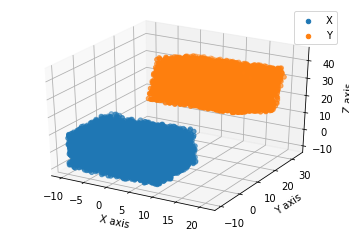

In [256]:
plot_data(X,Y, ['X','Y'])

## First extract the rotation/translation parameters using traditional fitting

In [208]:
def rotated_residual_m(params, args):
    """ cost between rotated and actual point for optimize.minimize
        angles: rotation angles, list of 3 angles
        x: input coordinate, shape (m,3)
        y: observed coordinate, shape (m,3)
        y_rotated: rotated coordinate
    """

    x = args['x']
    y = args['y']
    alpha,beta,gamma,tx,ty,tz = params
    y_rotated = rotate_translate(x, alpha=alpha,beta=beta,gamma=gamma,tx=tx,ty=ty,tz=tz)

    return np.linalg.norm(y-y_rotated)


# print ("Input shape:", X.shape, Y.shape)
# print (X[0], Y[0])
twopi = 2*np.pi

bounds_m = ((0,twopi), (0,twopi), (0,twopi), (None,None), (None,None), (None,None))
bounds_l = ((0,0,0,-np.inf,-np.inf,-np.inf), (twopi,twopi,twopi,np.inf,np.inf,np.inf))

print ("\nMINIMIZE...\n")
z = minimize(rotated_residual_m, x0=[0.1, 0.1, 0.1, 0, 0, 0], 
             method='SLSQP', bounds=bounds_m, args={'x':X,'y':Y})

np.set_printoptions(suppress=True)
if z.success:
#     print("Success")
    print ("Fitted Angles:", z.x[0:3])
    print (f"Expected angles = [{alpha}, {beta}, {gamma}]")
    print ("\nFitted Translations:", z.x[3:6])
    print (f"Extected translations = [{tx}, {ty}, {tz}]")

    mat_fitted = generate_rotation_matrix(z.x[0:3])
    print ("\nFitted Rotation Matrix:\n", mat_fitted)
    print ("Expected Rotation Matrix:\n", mat_expected)

else:
    print ("Failed")
# print ("\nDetails:\n", z)
    mat_expected = generate_rotation_matrix([alpha,beta,gamma])
    print (f"Expected angles = [{alpha}, {beta}, {gamma}]")
    print (f"Extected translations = [{tx}, {ty}, {tz}]")
    print ("Expected Rotation Matrix:\n", mat_expected)



MINIMIZE...

Fitted Angles: [0.99680469 1.49970259 2.99691304]
Expected angles = [1, 1.5, 3]

Fitted Translations: [ 9.99808504 19.99812779 30.00009413]
Extected translations = [10, 20, 30]

Fitted Rotation Matrix:
 [[ 0.03857056  0.90905457 -0.41488805]
 [ 0.05964999 -0.4165512  -0.90715323]
 [-0.9974739   0.01024133 -0.07029171]]
Expected Rotation Matrix:
 [[ 0.03821947  0.90910643 -0.41480692]
 [ 0.0595233  -0.4164443  -0.90721063]
 [-0.99749499  0.00998243 -0.0700293 ]]


## Split data into train/test


In [209]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

## Scale both X and Y data

In [210]:
xscaler = StandardScaler()
xscaler.fit(X_train)
X_train = xscaler.transform(X_train)
X_test = xscaler.transform(X_test)

yscaler = StandardScaler()
yscaler.fit(Y_train)
Y_train = yscaler.transform(Y_train)
Y_test = yscaler.transform(Y_test)
# Y_test[0:5,:]

In [211]:
# yscaler.inverse_transform(Y_test)[0:5,:]

## Plot train and test data

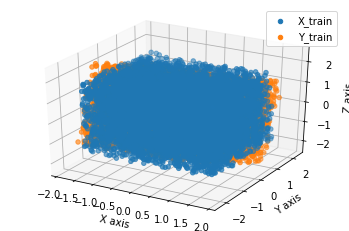

In [254]:
plot_data(X_train,Y_train,['X_train','Y_train']);

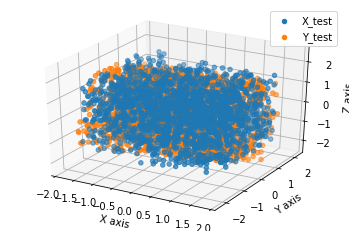

In [255]:
plot_data(X_test,Y_test,['X_test','Y_test'])

## define a model

In [258]:
def baseline_model(input_dim=100, lr=0.1, optimizer='adam', init='glorot_uniform', epochs=20):
   
    model = Sequential()
    model.add(Dense(input_dim, input_dim=input_dim, kernel_initializer=init, activation='relu')) 
#     model.add(Dropout(0.2))
    model.add(Dense(24, kernel_initializer=init,activation='relu'))
#     model.add(Dropout(0.2))
    model.add(Dense(3, kernel_initializer=init))
    
    # Compile model
#     decay_rate = lr / epochs
#     sgd = SGD(lr=lr, momentum=0.8, decay=decay_rate, nesterov=False)
#     adam = Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, decay=decay_rate, amsgrad=False)

#     model.compile(loss='mean_squared_error', optimizer='sgd') 
    model.compile(loss='mean_squared_error', optimizer=optimizer) 
#     print (model.summary())
    return model

## Cross Val Score

In [228]:
model = KerasRegressor(build_fn=baseline_model, input_dim=3, lr=0.1, epochs=200, batch_size=512, verbose=0)
kfold = KFold(n_splits=10)
scoring = 'neg_mean_squared_error'
results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring) 
print (f"Mean: {results.mean()}, Std: {results.std()}")

Mean: -0.05051167025622936, Std: 0.09729407771638919


## Fit model

MSE on test = 0.002370467483382886


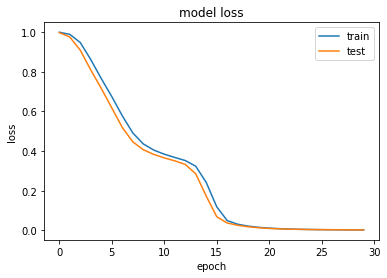

In [261]:
epochs = 30
model = baseline_model(input_dim=3, lr=0.1, epochs=epochs, init='normal', optimizer='adam' )
history = model.fit(X_train, Y_train, 
                    validation_data=(X_test, Y_test), 
                    epochs=epochs, batch_size=256, verbose=0)

# print (model.summary())

y_pred = model.predict(X_test)
print (f"MSE on test = {mse(Y_test, y_pred)}")
# print (history.history.keys())
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test']);

## Hyperparameter tuning: GridSearchCV

In [231]:
model = KerasRegressor(build_fn=baseline_model, input_dim=3, verbose=0)
optimizers = ['adam', 'sgd']
inits = ['glorot_uniform', 'normal']
epochs = [ 150, 200]
batches = [ 256, 512, 1024]
param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits) 
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_result = grid.fit(X_train, Y_train)

# summarize results
print(f"Best score: {grid_result.best_score_} for parameters: {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print(f"{mean}\t({stdev})\twith: {param}")


Best score: -0.0016555861589784583 for parameters: {'batch_size': 256, 'epochs': 200, 'init': 'normal', 'optimizer': 'adam'}
-0.11558270269471921	(0.15485054457283612)	with: {'batch_size': 256, 'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-0.02485858584143626	(0.006618601358990896)	with: {'batch_size': 256, 'epochs': 150, 'init': 'glorot_uniform', 'optimizer': 'sgd'}
-0.0023954090330328445	(0.00022137208611474894)	with: {'batch_size': 256, 'epochs': 150, 'init': 'normal', 'optimizer': 'adam'}
-0.01893354822720138	(0.004290895033)	with: {'batch_size': 256, 'epochs': 150, 'init': 'normal', 'optimizer': 'sgd'}
-0.002073567175457165	(0.0006565630750404928)	with: {'batch_size': 256, 'epochs': 200, 'init': 'glorot_uniform', 'optimizer': 'adam'}
-0.1232101221714174	(0.15722424619331665)	with: {'batch_size': 256, 'epochs': 200, 'init': 'glorot_uniform', 'optimizer': 'sgd'}
-0.0016555861589784583	(9.48992185408693e-05)	with: {'batch_size': 256, 'epochs': 200, 'init': 'normal', 

## Expectation: Y_test and Y_pred should be on top of each other for all points

Slice: 1468 1507


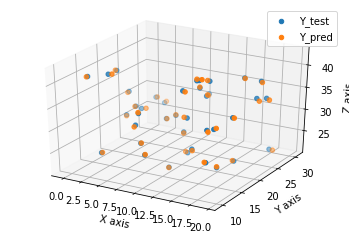

In [267]:
y_pred = grid.predict(X_test)
orig = yscaler.inverse_transform(Y_test)
pred = yscaler.inverse_transform(y_pred)
from random import randint
start = randint(0,len(orig))
end = randint(start+20, start+100)
plot_data(orig[start:end], pred[start:end],['Y_test','Y_pred'])
print ("Slice:", start, end)